In [14]:
from database.functions import get_factor, create_carry_factor
from database.functions import *
from simulation.functions import *
import pandas as pd
list = []
dollar = get_factor('dollar')
carry = get_factor('carry')

list.append(dollar)
list.append(carry)

x = pd.concat(list,  join = 'inner')
x


,rate
date,
1999-12-31,-0.031390
2000-01-31,-0.014326
2000-02-29,0.009558
2000-03-31,-0.036869
2000-04-30,-0.006947
...,...
2024-12-31,-0.000608
2025-01-31,-0.007681
2025-02-28,-0.007790


In [4]:
list  = []

list.append(0)

list

[0]

In [3]:
get_factor('dollarUSD')

,rate
date,
2000-01-31,0.031383
2000-02-29,0.013966
2000-03-31,-0.009587
2000-04-30,0.037307
2000-05-31,0.006876
...,...
2024-12-31,0.032047
2025-01-31,-0.000895
2025-02-28,-0.009551


In [8]:
from database.insert import *
from database.models import *
from database.functions import *
from database.session import session
from simulation.functions import *
import pandas as pd
import numpy as np
import scipy



base = 'CHF'


portfolio_name = 'portfolio' + base
x = get_portfolio_data(portfolio_name,base)

dollar  = create_dollar_factor(base)
carry = create_carry_factor(base)

ols_simulation = xgboost(x[1],x[5],carry,dollar)

hedge_ratios = ols_simulation[0]

df = simulate_portfolio(x[0],x[1],x[2],x[3],x[4],hedge_ratio = hedge_ratios,fx_portfolio = False)

plot_simulation(df)


1/9
2/9


KeyboardInterrupt: 

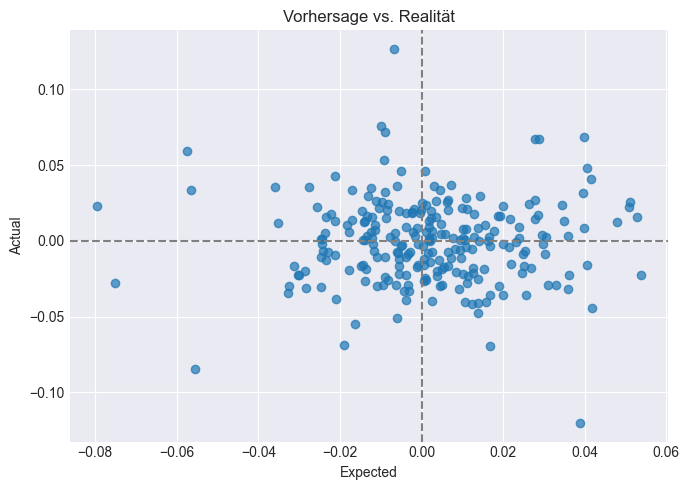

Trefferquote (Sign Match): 49.38%
Korrelation: -0.002
RMSE: 0.0349
            expected    actual
2005-01-31  0.050771  0.022167
2005-02-28  0.009143 -0.031594
2005-03-31  0.023228 -0.001084
2005-04-30  0.041838 -0.044661
2005-05-31 -0.003221 -0.029110
...              ...       ...
2024-11-30 -0.002986 -0.033214
2024-12-31 -0.002940 -0.007617
2025-01-31 -0.006415  0.005238
2025-02-28  0.012737  0.017790
2025-03-31  0.026270  0.024389

[243 rows x 2 columns]


In [6]:

expected = ols_simulation[1]
actual = x[5].shift(-1)



expected = expected['USD'].rename('expected')
actual = actual['USD'].rename('actual')

new = pd.concat([expected,actual],axis=1, join="inner")


new = new.dropna()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def evaluate_model(df, expected_col='expected', actual_col='actual'):
    # 1. Trefferquote: Wie oft stimmen die Vorzeichen überein?
    correct_sign = ((df[expected_col] > 0) & (df[actual_col] > 0)) | \
                   ((df[expected_col] < 0) & (df[actual_col] < 0))
    hit_ratio = correct_sign.mean()

    # 2. Korrelation
    correlation = df[[expected_col, actual_col]].corr().iloc[0, 1]

    # 3. RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(df[actual_col], df[expected_col]))

    # 4. Visualisierung
    plt.figure(figsize=(7, 5))
    plt.scatter(df[expected_col], df[actual_col], alpha=0.7)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel('Expected')
    plt.ylabel('Actual')
    plt.title('Vorhersage vs. Realität')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Ausgabe der Metriken
    print(f"Trefferquote (Sign Match): {hit_ratio:.2%}")
    print(f"Korrelation: {correlation:.3f}")
    print(f"RMSE: {rmse:.4f}")



evaluate_model(new)
# Beispielaufruf:
# evaluate_model(new)  # falls dein DataFrame "new" heißt

print(new)


In [35]:
from database.models import *
from database.session import session
from database.functions import *
import pandas as pd
import numpy as np


def create_carry_factor(base_currency='CHF'):
    """
    Constructs a time series of the global carry factor from the perspective of a given base currency.



    Parameters:
    -----------
    base_currency : str
        The investor's home currency (default is 'CHF').

    Returns:
    --------
    carry_df : pd.DataFrame
        A DataFrame with monthly dates as index and a single column 'carry_factor' containing the
        carry factor return at each time step.
    """

    # G10 currencies (excluding base_currency)
    g10 = ['EUR', 'JPY', 'CHF', 'GBP', 'AUD', 'CAD', 'NZD', 'NOK', 'SEK', 'USD']
    g10 = [curr for curr in g10 if curr != base_currency]

    spot_data = {}
    fwd_data = {}

    # 1. Load and resample spot and forward rates relative to the base currency
    for quote in g10:
        spot = get_fx(base_currency, quote, duration='Spot').resample('M').last()
        fwd = get_fx(base_currency, quote, duration='1M').resample('M').last()

        spot_data[quote] = spot['rate']
        fwd_data[quote] = fwd['rate']

    # Combine into DataFrames
    spot_df = pd.concat(spot_data, axis=1)
    fwd_df = pd.concat(fwd_data, axis=1)

    # 2. Calculate carry premium = (Spot - Forward) / Spot
    forward_logreturn = np.log(fwd_df.shift(1)/spot_df)
    spot_logreturn = np.log(spot_df / spot_df.shift(1))

    carry = pd.DataFrame()

    for date , row in forward_logreturn.iterrows(): # date ist der index und row ist Pandas Series-Objekt

        # Drop NaNs (falls vorhanden)
        row_clean = row.dropna()


        # Sortiere absteigend
        sorted_row = row_clean.sort_values(ascending=False)

        # Nimm die Top 3 und Bottom 3
        top3 = list(sorted_row.head(3).index)
        bottom3 = list(sorted_row.tail(3).index)

        top3_avg = spot_logreturn.loc[date, top3].mean()
        bottom3_avg = spot_logreturn.loc[date, bottom3].mean()
        carry_factor = top3_avg - bottom3_avg
        carry.at[date, 'carry_factor'] = carry_factor

    return carry











    return None

x = create_carry_factor('CHF')
print(x)


            carry_factor
1999-12-31           NaN
2000-01-31     -0.035583
2000-02-29     -0.025926
2000-03-31     -0.044782
2000-04-30     -0.038222
...                  ...
2024-12-31     -0.041991
2025-01-31     -0.015190
2025-02-28     -0.027065
2025-03-31     -0.052607
2025-04-30     -0.046866

[305 rows x 1 columns]


In [22]:
from database.functions import *

df = create_volatility_factor('CHF','USD')





print(df)

            volatilityUSDCHF
date                        
1999-12-31               NaN
2000-01-03               NaN
2000-01-04               NaN
2000-01-05               NaN
2000-01-06               NaN
...                      ...
2025-04-01               1.0
2025-04-02               1.0
2025-04-03               1.0
2025-04-04               1.0
2025-04-07               NaN

[6592 rows x 1 columns]


In [5]:
    g10 = ['EUR', 'JPY', 'CHF', 'GBP', 'AUD', 'CAD', 'NZD', 'NOK', 'SEK', 'USD']
    g10 = [curr for curr in g10 if curr != 'USD']

    weights = [1/len(g10) for currncy in g10]
    weights

[0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111]